In [2]:
from matplotlib import pyplot as plt
import seaborn as sns

import utils

groans = utils.load_groan_tuples()
groans[:5]

[['Modern warfare', 'Lightsaber combat'],
 ['Lizard', 'Dragon'],
 ['Shape', 'Shapeshifting'],
 ['Prime number', 'Optimus Prime'],
 ['Civil war', 'Civil War (comics)']]

In [3]:
len(groans)

109

In [4]:
from matplotlib.ticker import FuncFormatter

def munge_datestr(datestr):
    """Given a year-month string like '2020-7', return a canonical int representation
    equal to the number of months since birth of Jesus (plus 12 technically, cause the
    calendar starts at 1 AD rather than 0. Whatever.)
    """
    year, month = map(int, datestr.split('-'))
    return year*12 + month

def munge_dt(dt):
    return dt.year * 12 + dt.month

def unmunge_date(dateint):
    dateint = int(dateint) # matplotlib converts to float, idk why
    year = (dateint-1) // 12
    # 0 is actually 12
    month = (dateint % 12) or 12
    return f'{year}-{month}'

def _load_time_series(title):
    path = utils.ts_path_for_title(title)
    with open(path) as f:
        pairs = [line.strip().split(',') for line in f]
        return [ (munge_datestr(date), int(size)) for (date, size) in pairs ]

import groan
# dynamic version, working directly from revision data
def load_time_series(title):
    h = groan.History.load_title(title)
    sizes = h.size_per_month()
    return [ (munge_dt(dt), int(size)) for (dt, size) in sizes.items() ]

def pad_time_series(ts, start, end):
    left_pad = [ (dateint, 0) for dateint in range(start, ts[0][0]) ]
    right_pad_value = ts[-1][1]
    right_pad = [ (dateint, right_pad_value) for dateint in range(ts[-1][0], end) ]
    return left_pad + ts + right_pad
    
def pad_time_serieses(ss):
    """Given a dict mapping titles to time series, return a dict of the same shape
    where the time series have the same range.
    """
    start = min([s[0][0] for s in ss.values()])
    end = max([s[-1][0] for s in ss.values()])
    return {title: pad_time_series(ts, start, end) for (title, ts) in ss.items()}

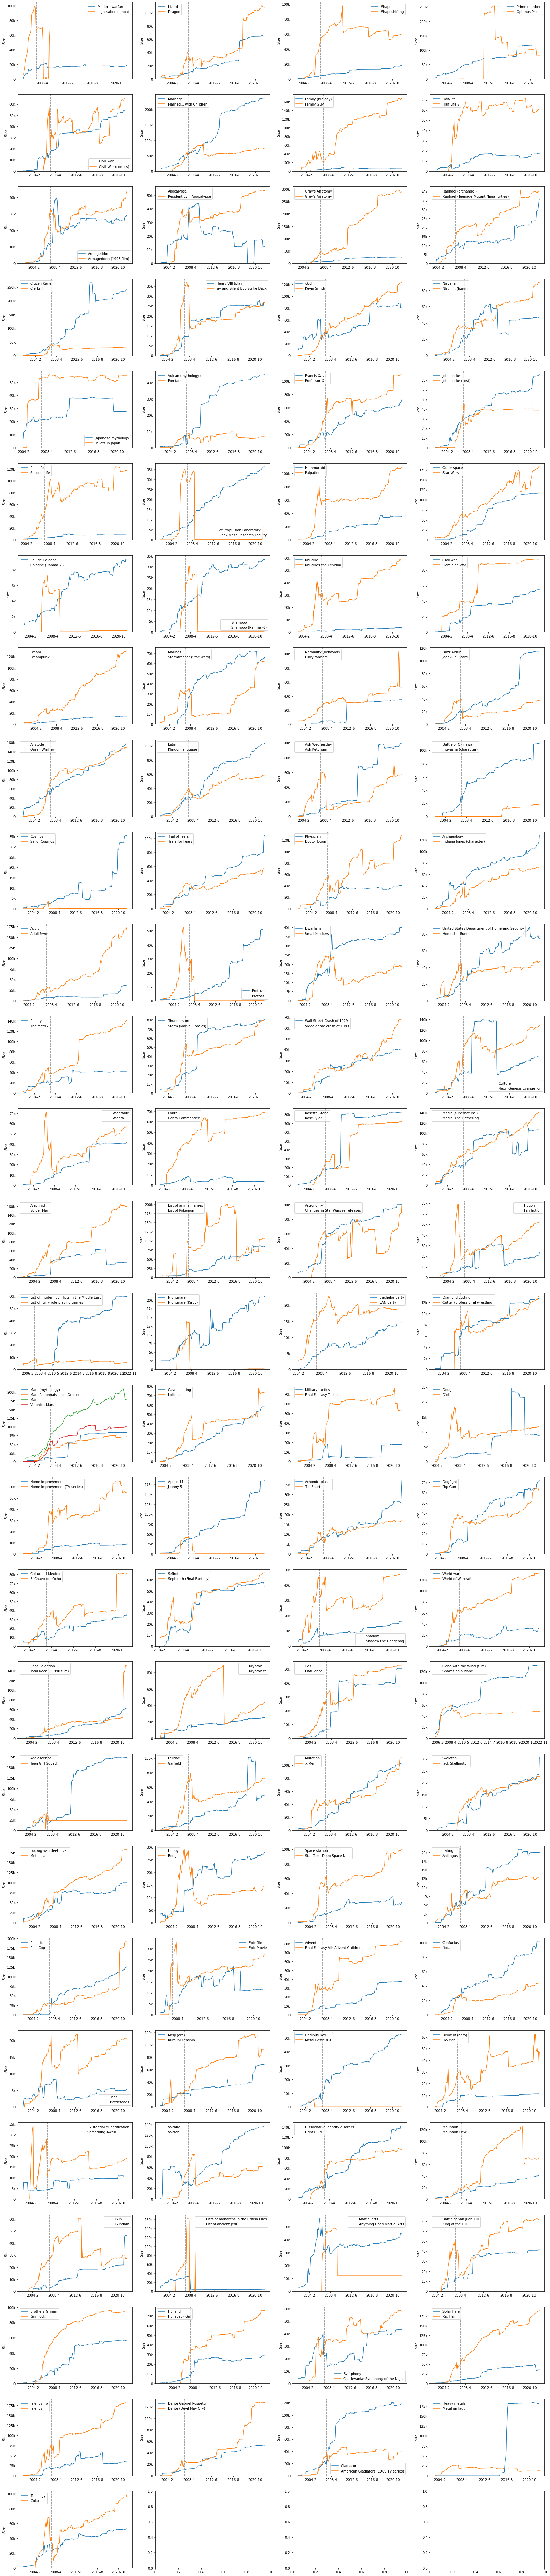

In [7]:
import math

FS = (11, 7)
def plot_groan(groan, ax=None):
    # Not too hard to generalize this to n > 2, actually
    serieses = { title: load_time_series(title) for title in groan }
    padded = pad_time_serieses(serieses)
    
    if ax is None:
        fig, ax = plt.subplots(figsize=FS)
    for title, ts in padded.items():
        x, y = zip(*ts)
        #x = [unmunge_date(d) for d in x]
        ax.plot(x, y, label=title)
    ax.legend()
    ax.set_ylim(0)
    ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: unmunge_date(x)))
    ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: '0' if x == 0 else f'{int(x)//1000}k'))
    # SA blog post game out 2007-06-05, so the average size in May is probably the best approximation of how
    # big articles were when the post was being written
    ax.vlines(munge_datestr('2007-05'), *ax.get_ylim(),
              colors='grey',
              linestyle='--',
             )
    ax.set_ylabel('Size')
    return ax

#ax = plot_groan(groans[0]);

n = len(groans)
cols = 4
rows = math.ceil(n / cols)
fig, axes = plt.subplots(rows, cols, figsize=(7*cols, 5*rows))
for i, ax in enumerate(axes.flatten()):
    if i >= n:
        break
    plot_groan(groans[i], ax=ax)
    
fig.savefig(f'all_groans.png', dpi=100, bbox_inches='tight')

In [6]:
len(groans)

49

In [5]:
assert False

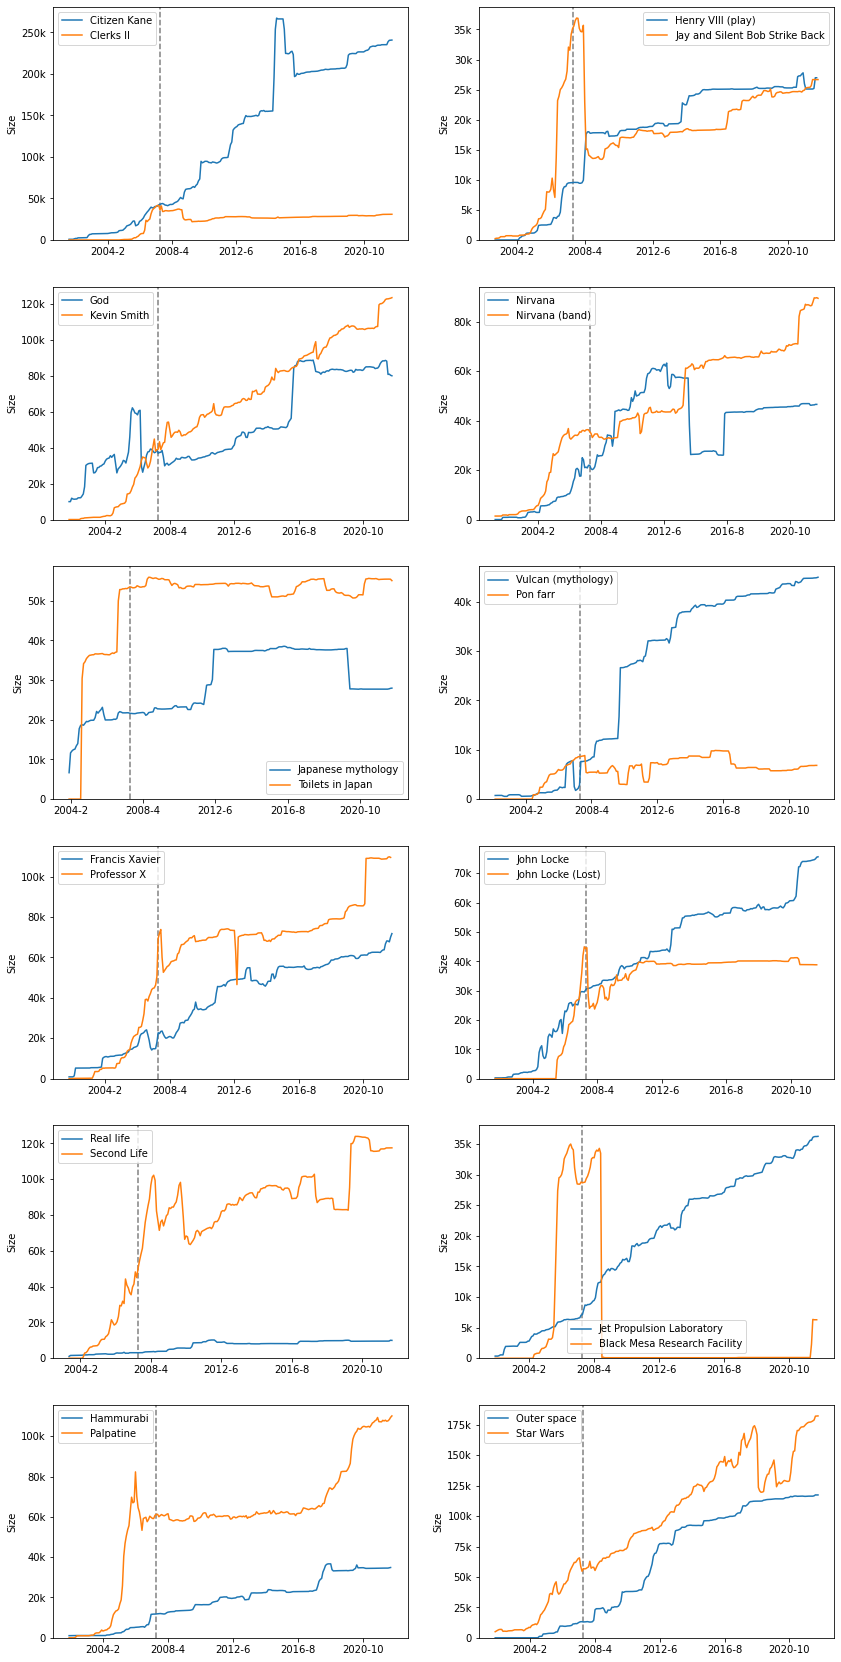

In [10]:
#n = len(groans)
n = 12
offset = 12
cols = 2
rows = math.ceil(n / cols)
fig, axes = plt.subplots(rows, cols, figsize=(7*cols, 5*rows))
for i, ax in enumerate(axes.flatten()):
    if i+offset >= len(groans):
        break
    plot_groan(groans[i+offset], ax=ax)
    
fig.savefig(f'foo{offset}.png', dpi=140)